### Steps:

- Download and arange CatsVsDogs data
- Setup ConvNet
- Learn image_dataset_from_directory tf.Dataset
- Apply data augmentation

### Covered topics and learning objectives

- Regularization for image classification
- Data augmentation


In [13]:
from tensorflow import keras
keras.__version__

'3.4.1'

# Using ConvNets with small datasets

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on
classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000
pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We
will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be
achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce
_data augmentation_, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve
our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: _doing feature extraction
with a pre-trained network_ (this will get us to an accuracy of 90% to 93%), and _fine-tuning a pre-trained network_ (this will get us to
our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a
pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer
vision with small datasets.


## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can
potentially suffice if the model is small and well-regularized and if the task is simple.
Because convnets learn local, translation-invariant features, they are very
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.


## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at:
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)


Unsurprisingly, the original dogs-versus-cats Kaggle competition, all the way back in 2013, was won by entrants who used convnets. The best entries achieved up to 95% accuracy. In this example, we will get fairly close to this accuracy (in the next section), even though we will train our models on less than 10% of the data that was available to the competitors.

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing the data, we’ll create a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 1,000 samples of each class. Why do this? Because many of the image datasets you’ll encounter in your career only contain a few thousands of samples, not tens of thousands. Having more data available would make the problem easier—so it’s good practice to learn with a small dataset.

Let’s make it happen in a couple calls to shutil:


In [14]:
import os, glob, shutil, pathlib
from pathlib import Path


In [15]:
# REPO_DIR = Path(os.getcwd()).parent

# # Note: Please put the data into the data folder in the root of the repo for the following to work!
# original_dir = REPO_DIR / "data/kaggle_original_data/train"
# new_base_dir = REPO_DIR / "data/cats_vs_dogs_small"

In [16]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

# make_subset("train", start_index=0, end_index=1000)
# make_subset("validation", start_index=1000, end_index=1500)
# make_subset("test", start_index=1500, end_index=2500)

In [17]:
# !tar xzvf data/cvd.tar.gz -C data
# %ls

## Github repo:

In [18]:
# Where the text files are going to live.
dataset_path = "./data/cats_vs_dogs_small"

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):
    #os.mkdir(dataset_path)

    # Clone the repo.
    !git clone https://github.com/hrbjoern/2024-08-14_deep-learning-for-comp-vision.git

    # Move the files to the right place.
    !mv 2024-08-14_deep-learning-for-comp-vision/data .
    !rm -rf 2024-08-14_deep-learning-for-comp-vision/


In [19]:
!ls .
!pwd .
new_base_dir = './data/cats_vs_dogs_small'
print(new_base_dir)
!ls

data  sample_data
/content
./data/cats_vs_dogs_small
data  sample_data


## Julien's solution:

In [20]:
# import tensorflow_datasets as tfds

# ds = tfds.load('cats_vs_dogs', split=["train[:1000]", "train[1000:1500]", "train[1500:2500]"], as_supervised=True)

# train = ds[0]
# validation = ds[1]
# test = ds[2]

So we now have 2,000 training images, 1,000 validation images, and 2,000 test images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.


### Building your model

We will reuse the same general model structure you saw in the first example: the convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

But because we’re dealing with bigger images and a more complex problem, we’ll make our model larger, accordingly: it will have two more Conv2D MaxPooling2D stages. This serves both to augment the capacity of the model and to further reduce the size of the feature maps so they aren’t overly large when we reach the Flatten layer. Here, because we start from inputs of size 180 pixels × 180 pixels (a somewhat arbitrary choice), we end up with feature maps of size 7 × 7 just before the Flatten layer.

Note: The depth of the feature maps progressively increases in the model (from 32 to 256), whereas the size of the feature maps decreases (from 180 × 180 to 7 × 7). This is a pattern you’ll see in almost all convnets.

Because we’re looking at a binary-classification problem, we’ll end the model with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the model is looking at one class or the other.

One last small difference: we will start the model with a Rescaling layer, which will rescale image inputs (whose values are originally in the \[0, 255\] range) to the \[0, 1\] range.

#### Instantiating a small convnet for dogs vs. cats classification


In [21]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Let’s look at how the dimensions of the feature maps change with every successive layer:


In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

For the compilation step, you’ll go with the RMSprop optimizer, as usual. Because you ended the model with a single sigmoid unit, you’ll use binary crossentropy as the loss.

#### Configuring the model for training


In [23]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

As you know by now, data should be formatted into appropriately preprocessed floating-point tensors before being fed into the model. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:

Read the picture files.
Decode the JPEG content to RGB grids of pixels.
Convert these into floating-point tensors.
Resize them to a shared size (we’ll use 180 x 180).
Pack them into batches (we’ll use batches of 32 images).
It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. In particular, Keras features the utility function image_dataset_from_directory, which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors. This is what you’ll use here.

Calling image_dataset_from_directory(directory) will first list the subdirectories of directory and assume each one contains images from one of your class. It will then index the image files in each subdirectory. Finally, it will create and return a tf.data.Dataset object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.


In [24]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

print(new_base_dir)
!ls "{new_base_dir}"
!ls "{new_base_dir}/train"

!ls ./data/cats_vs_dogs_small/train/

train_dataset = image_dataset_from_directory(
    new_base_dir+"/train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/test",
    image_size=(180, 180),
    batch_size=32)

./data/cats_vs_dogs_small
test  train  validation
cat  dog
cat  dog
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### UNDERSTANDING TENSORFLOW DATASET OBJECTS

TensorFlow makes available the tf.data API to create efficient input pipelines for machine learning models. Its core class is tf.data.Dataset.

A Dataset object is an iterator: you can use it in a for loop. It will typically return batches of input data and labels. You can pass a Dataset object directly to the fit() method of a Keras model.

The Dataset class handles many key features that would otherwise be cumbersome to implement yourself, a in particular asynchronous data prefetching (preprocessing the next batch of data while the previous one is being handled by the model, which keeps execution flowing without interruptions).

The Dataset class also exposes a functional-style API for modifying datasets. Here’s a quick example: let’s create a Dataset instance from a NumPy array of random numbers. We’ll consider 1000 samples, where each sample is a vector of size 16.


In [25]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

At first, our dataset just yield single samples:


In [26]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


You can use the .batch() method to batch the data:


In [27]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


More broadly, you have access to a range of useful dataset methods, such as:

- .shuffle(buffer_size) will shuffle elements within a buffer.
- .prefetch(buffer_size) will prefetch a buffer of elements in GPU memory to achieve better device utilization.
- .map(callable) will apply an arbitrary transformation to each element of the dataset (the function callable, expected to take as input a single element yielded by the dataset).

The method .map() in particular is one that you will use often. Here’s an example: let’s use it to reshape the elements in our toy dataset from shape (16,) to shape (4, 4):


In [28]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


You’re about to see more map() action in this chapter.


Let’s look at the output of one of these Dataset objects: it yields batches of 180 × 180 RGB images (shape (32, 180, 180, 3)) and integer labels (shape (32,)). There are 32 samples in each batch (the batch size).


In [29]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Let’s fit the model on our dataset. We use the validation_data argument in fit() to monitor validation metrics on a separate Dataset object.

Note that we also use a ModelCheckpoint callback to save the model after each epoch. We configure it with the path where to save the file, as well as the arguments save_best_only=True and monitor="val_loss": they tell the callback to only save a new file (overwriting any previous one) when the current value of the val_loss metric is lower than at any previous time during training. This guarantees that your saved file will always contain the state of the model corresponding to its best-performing training epoch, in terms of its performance on the validation data. As a result, we won’t have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file.


In [30]:
EPOCHS = 30

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.4868 - loss: 0.7096 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5240 - loss: 0.6973 - val_accuracy: 0.5120 - val_loss: 0.6863
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5328 - loss: 0.6911 - val_accuracy: 0.6510 - val_loss: 0.6473
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6251 - loss: 0.6562 - val_accuracy: 0.5970 - val_loss: 0.6524
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6409 - loss: 0.6384 - val_accuracy: 0.6580 - val_loss: 0.6953
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6764 - loss: 0.5967 - val_accuracy: 0.6790 - val_loss: 0.6041
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7102 - loss: 0.5638 - val_accuracy: 0.6620 - val_loss: 0.6112
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7231 - loss: 0.5415 - val_accuracy: 0.6720 -

Let’s plot the loss and accuracy of the model over the training and validation data during training.


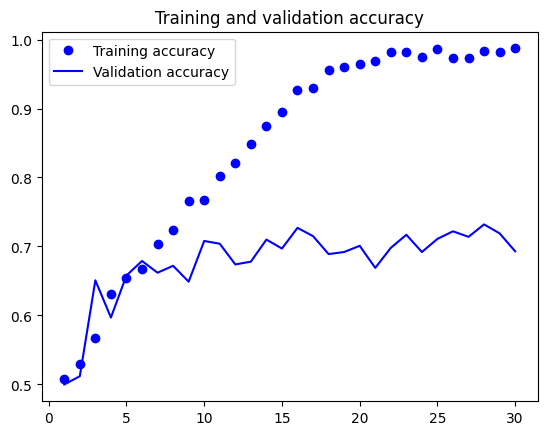

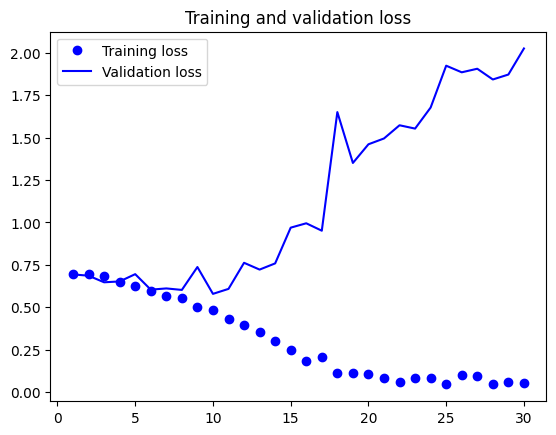

In [31]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

(When you run for 30 epochs,) These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 75%. The validation loss reaches its minimum after only ten epochs and then stalls, whereas the training loss keeps decreasing linearly as training proceeds.

Let’s check the test accuracy. We’ll reload the model from its saved file so as to evaluate as it was before it started overfitting.


In [32]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6995 - loss: 0.6050
Test accuracy: 0.689


We get a test accuracy of 69.5% (due to the randomness of neural network initializations, you may get numbers within one percentage point of that).

Because you have relatively few training samples (2,000), overfitting will be your number-one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep-learning models: data augmentation.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by adding a number of data augmentation layers at the start of your model. Let’s get started with an example: here’s a Sequential model that chains several random image transformations. In our model, we’d include it right before the Rescaling layer.


In [33]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

These are just a few of the layers available (for more, see the Keras documentation). Let’s quickly go over this code:

RandomFlip("horizontal") will apply horizontal flipping to a random 50% of the images that go through it.
RandomRotation(0.1) will rotation the input images by a random value in the range \[-10%, +10%\] (these are fractions of a full circle—in degrees the range would be \[-36 degrees, +36 degrees\]).
RandomZoom(0.2) will zoom in or out of the image by a random factor in the range \[-20%, +20%\].
Let’s look at the augmented images.


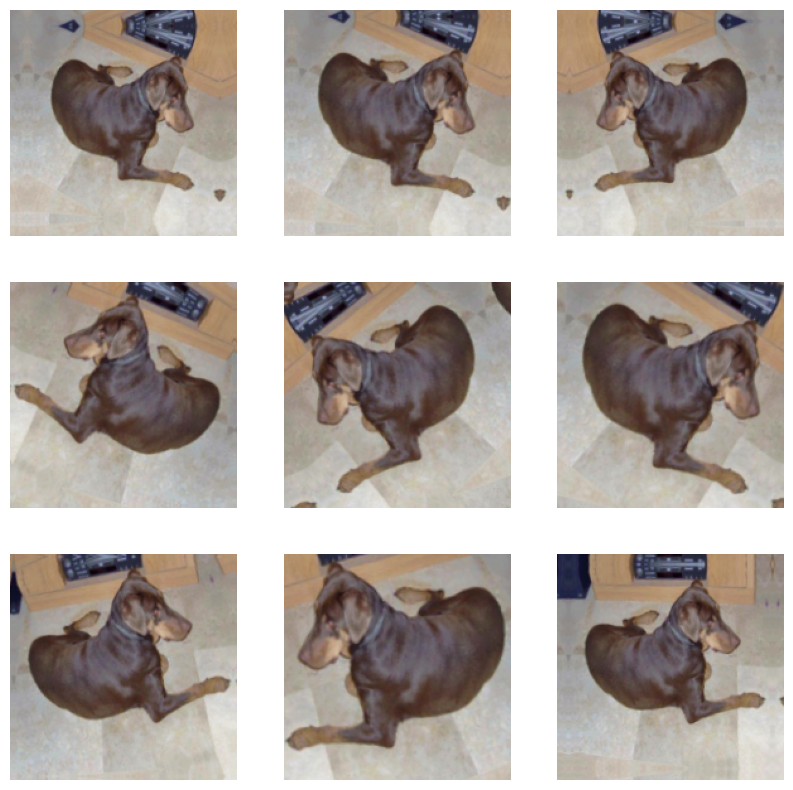

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

If you train a new model using this data-augmentation configuration, the model will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, you’ll also add a Dropout layer to your model, right before the densely connected classifier.

One last thing you should know about random image augmentation layers: just like Dropout, they’re inactive during inference (when you call predict() or evaluate()). During evaluation, your model will behave just the same as when it did not include data augmentation and dropout.


In [35]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Let’s train the model using data augmentation and dropout. Because we expect overfitting to occur much later during training, we will train for 3x as many epochs—one hundred.


In [36]:
EPOCHS = 100
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.5078 - loss: 0.8315 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5009 - loss: 0.6968 - val_accuracy: 0.5010 - val_loss: 0.6962
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5381 - loss: 0.6909 - val_accuracy: 0.5290 - val_loss: 0.6793
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5792 - loss: 0.6808 - val_accuracy: 0.6280 - val_loss: 0.6545
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6259 - loss: 0.6590 - val_accuracy: 0.6330 - val_loss: 0.6391
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6291 - loss: 0.6407 - val_accuracy: 0.5830 - val_loss: 0.6566
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6403 - loss: 0.6372 - val_accuracy: 0.6490 - val_loss: 0.6291
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6593 - loss: 0.6011 - val_accuracy: 0.

Let’s plot the results again. Thanks to data augmentation and dropout, we start overfitting much later, around epochs 60-70 (compared to epoch 10 for the original model). The validation accuracy ends up consistently in the 80-85% range—a big improvement over our first try.


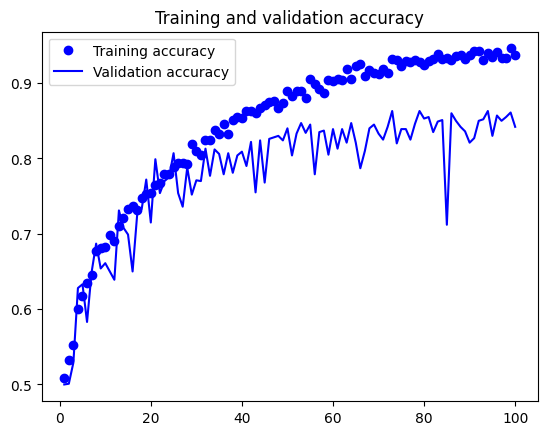

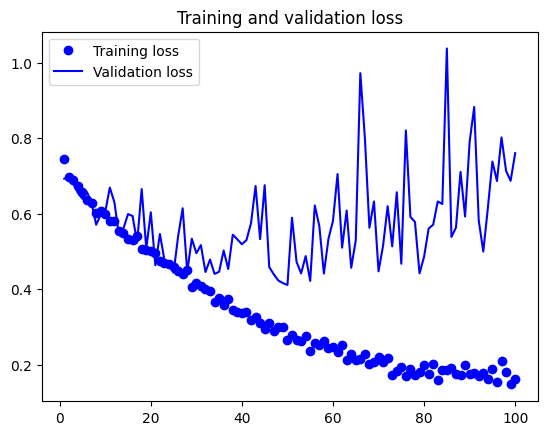

In [37]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Let’s check the test accuracy:


In [38]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8232 - loss: 0.4343
Test accuracy: 0.826


We get a test accuracy of 83.5%. It’s starting to look good!

By further tuning the model’s configuration (such as the number of filters per convolution layer, or the number of layers in the model), you may be able to get an even better accuracy, likely up to 90%. But it would prove difficult to go any higher just by training your own convnet from scratch, because you have so little data to work with. As a next step to improve your accuracy on this problem, you’ll have to use a pretrained model, which is the focus of the next two sections.
